In [3]:
library(tidyverse)
library(caret)
library(Biobase)
library(PharmacoGx)
library(Hmisc)
library(glmnet)
library(mRMRe)
library(SummarizedExperiment)
library(ggplot2)
library(EDASeq)
library(dplyr)
library(ggpubr)
library(gridExtra)
library(RColorBrewer)
library(ggfortify)
library(FactoMineR)
library(factoextra)
library(pheatmap)
library(AnnotationHub)
library(ensembldb)
library(Biostrings)
library(corrplot)
library(ComplexHeatmap)

In [4]:
options(stringsAsFactors = F)

# (1) <u>Identify Transcript Stability across Biological Replicates</u>

### Read in PSets

In [5]:
gCSI <- readRDS("gCSI.rds")

In [6]:
CCLE <- readRDS("CCLE.rds")

In [7]:
GDSC <- readRDS("GDSC2.rds")

### Read in biological replicates

In [8]:
load("inter.RData") #intersected_rnacells

### SummarizeMolecularProfiles (transcript counts) for biological replicates

In [258]:
gCSI_rna <- summarizeMolecularProfiles(pSet = gCSI, mDataType = "Kallisto_0.46.1.isoforms.counts", cell.lines = intersected_rnacells)
GDSC_rna <- summarizeMolecularProfiles(pSet = GDSC, mDataType = "Kallisto_0.46.1.isoforms.counts", cell.lines = intersected_rnacells)
CCLE_rna <- summarizeMolecularProfiles(pSet = CCLE, mDataType = "Kallisto_0.46.1.isoforms.counts", cell.lines = intersected_rnacells)

Summarizing Kallisto_0.46.1.isoforms.counts molecular data for:	gCSI



  |======================================================================| 100%


Summarizing Kallisto_0.46.1.isoforms.counts molecular data for:	GDSC_v2



  |======================================================================| 100%


### Determine pearson correlation for each transcript across datasets (gCSI vs CCLE; gCSI vs GDSC; GDSC vs CCLE), but only take median correlation for each transcript

In [9]:
transcripts <- gCSI_rna@elementMetadata$transcript_id
transcript_stability <- data.frame(matrix(nrow=length(transcripts), ncol=12))
colnames(transcript_stability) <- c("transcript_id", "pearson", "gcsi_mad","ccle_mad","gdsc_mad", "combined_mad","gcsi_median","gdsc_median","ccle_median", "gcsi_ccle_mad", "gcsi_gdsc_mad", "gdsc_ccle_mad")
transcript_stability$transcript_id <- transcripts
rownames(transcript_stability) <- transcript_stability$transcript_id

In [ ]:
for (i in 1:length(transcripts)){
  print(i)
  #gCSI vs CCLE
  expr_gcsi <- as.numeric(gCSI_rna@assays@data$exprs[i,])
  expr_gcsi_mad <- mad(expr_gcsi)
  expr_gcsi_med <- median(expr_gcsi)
  expr_ccle <- as.numeric(CCLE_rna@assays@data$exprs[i,])
  expr_ccle_mad <- mad(expr_ccle)
  expr_ccle_med <- median(expr_ccle)
  p_1 <- cor(expr_gcsi, expr_ccle, method = "pearson")
  
  #gCSI vs GDSC
  expr_gdsc <- as.numeric(GDSC_rna@assays@data$exprs[i,])
  expr_gdsc_mad <- mad(expr_gdsc)
  expr_gdsc_med <- median(expr_gdsc)
  p_2 <- cor(expr_gcsi, expr_gdsc, method = "pearson")
  
  #CCLE vs GDSC
  p_3 <- cor(expr_ccle, expr_gdsc, method = "pearson")
  
  #Combined
  combined <- c(expr_gcsi, expr_ccle, expr_gdsc)
  expr_combined_mad <- mad(combined)
  expr_combined_med <- median(combined)
  
  #gCSI/CCLE MAD
  gcsi_ccle_mad <- c(expr_gcsi, expr_ccle)
  gcsi_ccle_mad <- mad(gcsi_ccle_mad)
  
  #gCSI/GDSC MAD
  gcsi_gdsc_mad <- c(expr_gcsi, expr_gdsc)
  gcsi_gdsc_mad <- mad(gcsi_gdsc_mad)
  
  #GDSC/CCLE MAD
  gdsc_ccle_mad <- c(expr_gdsc, expr_ccle)
  gdsc_ccle_mad <- mad(gdsc_ccle_mad)
  
  if (is.na(p_1) | is.na(p_2) | is.na(p_3)){
    next
    
  } else {
  
  p_median <- median(p_1, p_2, p_3)
  #assign median correlation to df
  transcript_stability[i,"pearson"] <- p_median
  transcript_stability[i,"gcsi_mad"] <- expr_gcsi_mad
  transcript_stability[i,"ccle_mad"]<- expr_ccle_mad
  transcript_stability[i,"gdsc_mad"] <- expr_gdsc_mad
  transcript_stability[i,"gcsi_ccle_mad"] <- gcsi_ccle_mad
  transcript_stability[i,"gcsi_gdsc_mad"] <- gcsi_gdsc_mad
  transcript_stability[i,"gdsc_ccle_mad"] <- gdsc_ccle_mad
  transcript_stability[i,"combined_mad"] <- expr_combined_mad
  transcript_stability[i,"gcsi_median"] <- expr_gcsi_med
  transcript_stability[i,"ccle_median"] <- expr_ccle_med
  transcript_stability[i,"gdsc_median"] <- expr_gdsc_med
  
  }
}

In [285]:
load("transcript_stability_MAD_count_norm.RData")

### Identify MAD (Median Absolute Deviation) for each transcript across datasets (N=227912)

In [286]:
#remove transcripts that have no correlation (NA) - 8% of transcripts
transcript_stability <- transcript_stability[-which(is.na(transcript_stability$pearson)),]

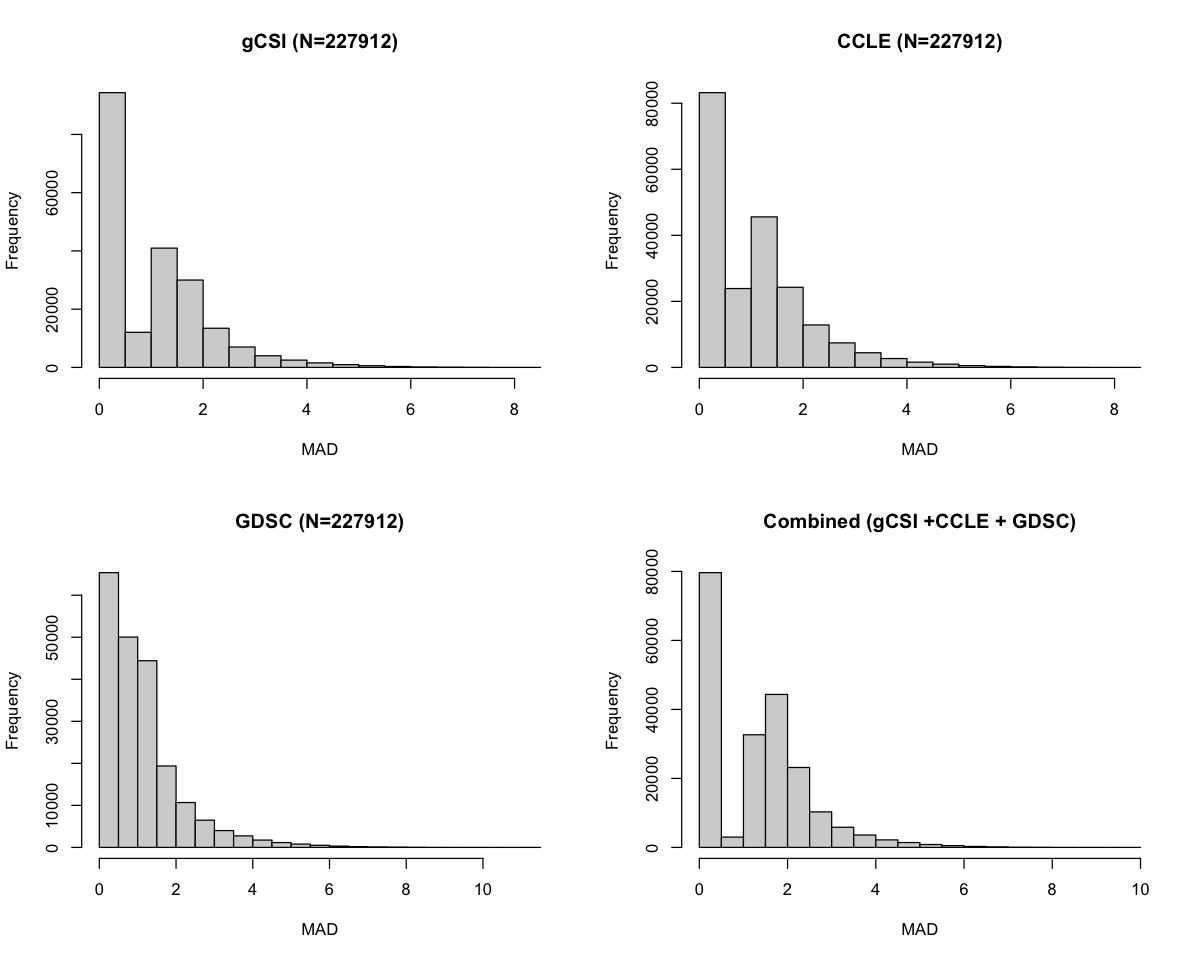

In [18]:
#High MAD (in Combined) shows unstable transcripts, which
#might be because of biological variations, sensitivity to cell culture or any other protocol differences
options(repr.plot.width=10, repr.plot.height=8)
layout(matrix(1:4,2,2,byrow=TRUE))
hist(transcript_stability$gcsi_mad, xlab='MAD', main="gCSI (N=227912)")
hist(transcript_stability$ccle_mad, xlab='MAD', main="CCLE (N=227912)")
hist(transcript_stability$gdsc_mad, xlab='MAD', main="GDSC (N=227912)")
hist(transcript_stability$combined_mad, xlab='MAD', main="Combined (gCSI +CCLE + GDSC)")

### Identify MAD for protein-coding transcripts across datasets (N=84107)

In [287]:
protein_transcripts <- gCSI@molecularProfiles$Kallisto_0.46.1.isoforms@elementMetadata$transcript_id[which(gCSI@molecularProfiles$Kallisto_0.46.1.isoforms@elementMetadata$transcript_type == "protein_coding")]
transcript_stability_p <- transcript_stability[protein_transcripts[which(protein_transcripts %in% rownames(transcript_stability))],]

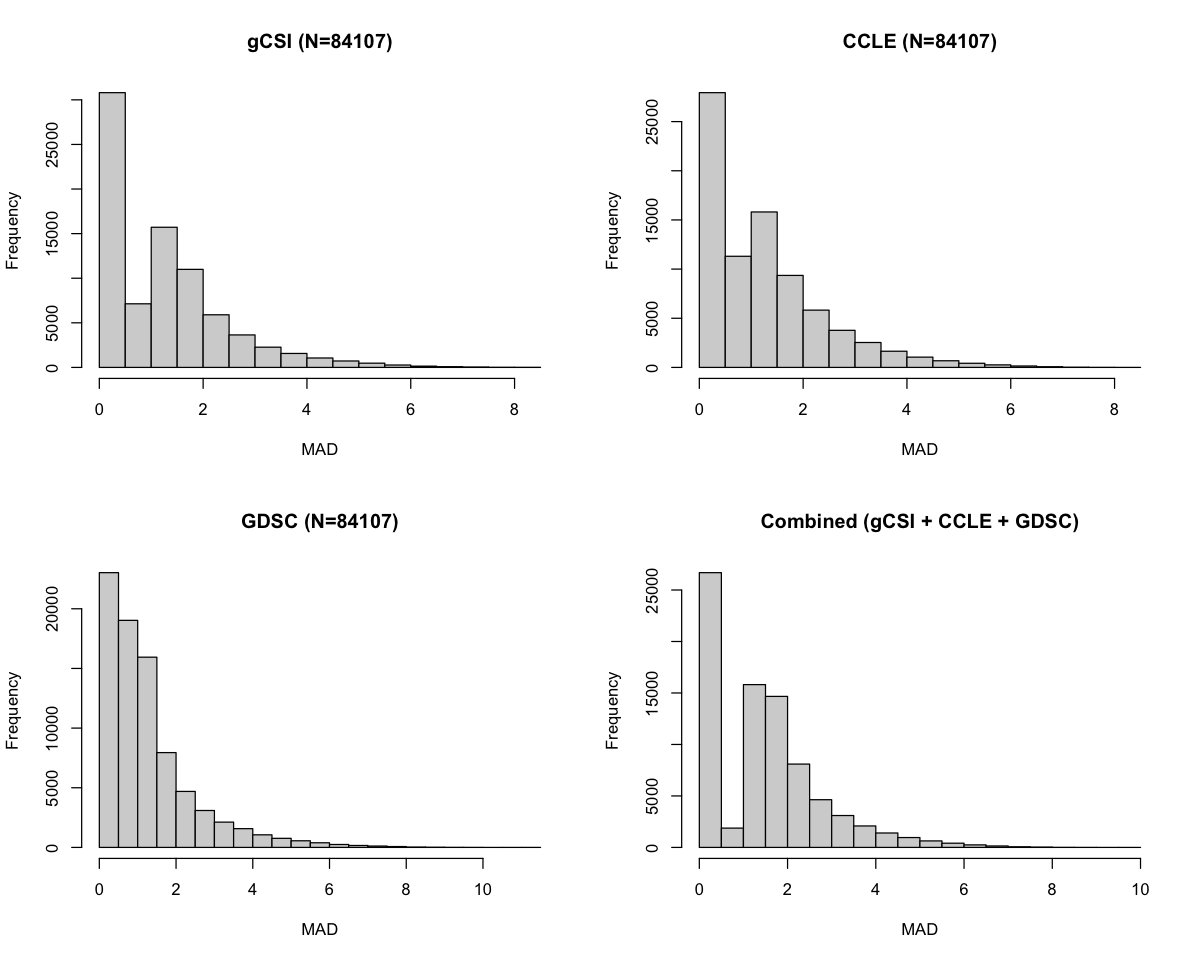

In [20]:
options(repr.plot.width=10, repr.plot.height=8)
layout(matrix(1:4,2,2,byrow=TRUE))
hist(transcript_stability_p$gcsi_mad, xlab='MAD', main="gCSI (N=84107)")
hist(transcript_stability_p$ccle_mad, xlab='MAD', main="CCLE (N=84107)")
hist(transcript_stability_p$gdsc_mad, xlab='MAD', main="GDSC (N=84107)")
hist(transcript_stability_p$combined_mad, xlab='MAD', main="Combined (gCSI + CCLE + GDSC)")

### Correlation across biological replicates for each proten-coding transcript (N=84107)

In [288]:
expr_gcsi_p <- gCSI_rna@assays@data$expr[protein_transcripts,]
expr_ccle_p <- CCLE_rna@assays@data$expr[protein_transcripts,]
expr_gdsc_p <- GDSC_rna@assays@data$expr[protein_transcripts,]

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



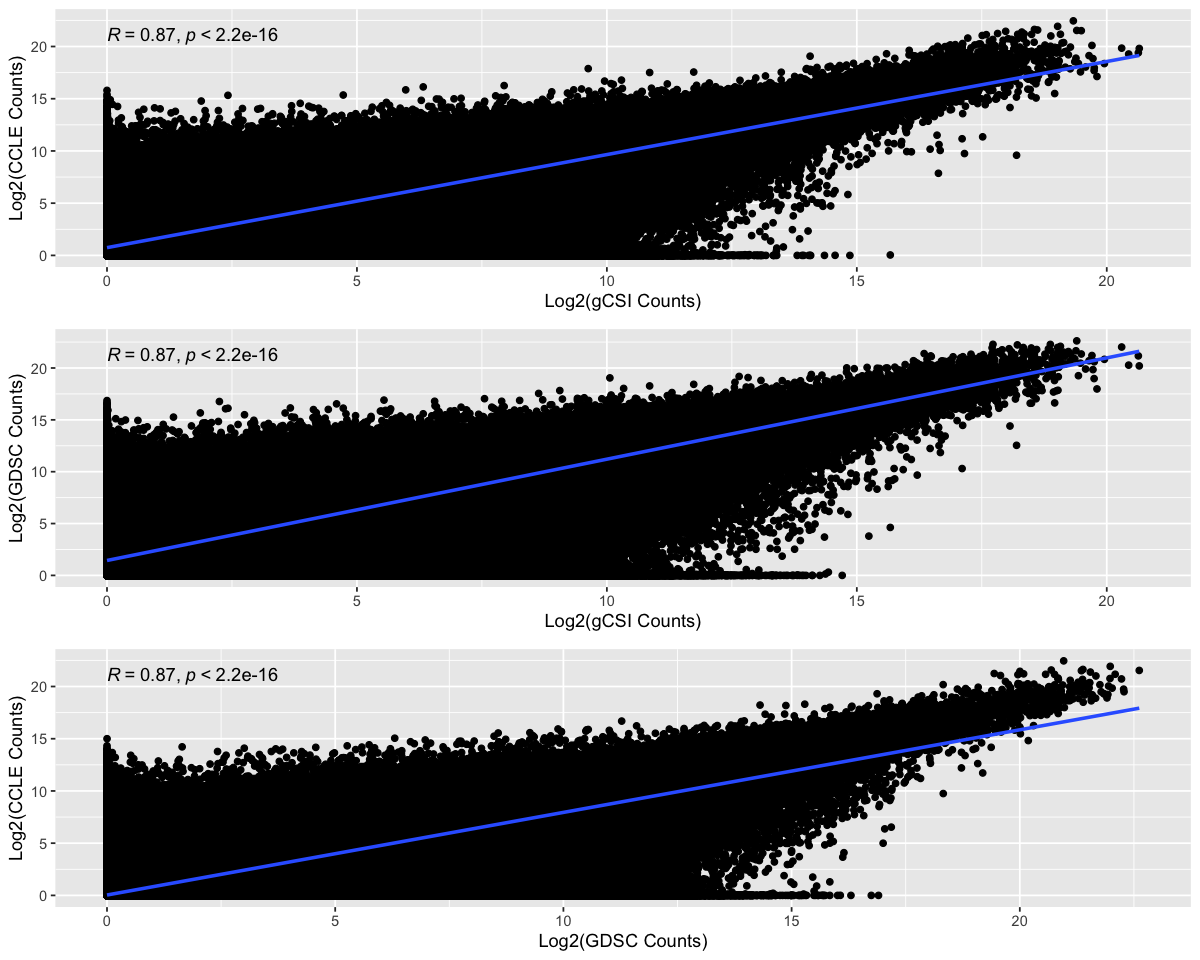

In [23]:
gcsi_ccle <- qplot(as.vector(t(expr_gcsi_p)), y = as.vector(t(expr_ccle_p)), xlab = "Log2(gCSI Counts)", ylab = "Log2(CCLE Counts)") + geom_smooth(method="lm") + stat_cor(method="pearson")
gcsi_gdsc <- qplot(as.vector(t(expr_gcsi_p)), y = as.vector(t(expr_gdsc_p)), xlab = "Log2(gCSI Counts)", ylab = "Log2(GDSC Counts)") + geom_smooth(method="lm") + stat_cor(method="pearson")
gdsc_ccle <- qplot(as.vector(t(expr_gdsc_p)), y = as.vector(t(expr_ccle_p)), xlab = "Log2(GDSC Counts)", ylab = "Log2(CCLE Counts)") + geom_smooth(method="lm") + stat_cor(method="pearson")
options(repr.plot.width=10, repr.plot.height=8)
grid.arrange(gcsi_ccle, gcsi_gdsc, gdsc_ccle)

### MAD threshold definition for proten-coding transcript (N=84107)

#### Remove transcripts with 0 expression & keep resulting transcripts shared between datasets

In [289]:
expr_gcsi_p <- expr_gcsi_p[apply(expr_gcsi_p[,-1], 1, function(x) !all(x==0)),]
expr_ccle_p <- expr_ccle_p[apply(expr_ccle_p[,-1], 1, function(x) !all(x==0)),]
expr_gdsc_p <- expr_gdsc_p[apply(expr_gdsc_p[,-1], 1, function(x) !all(x==0)),]

In [290]:
intersected_t <- Reduce(intersect, list(rownames(expr_gcsi_p), rownames(expr_ccle_p), rownames(expr_gdsc_p)))
expr_gcsi_p <- expr_gcsi_p[intersected_t,]
expr_ccle_p <- expr_ccle_p[intersected_t,]
expr_gdsc_p <- expr_gdsc_p[intersected_t,]

transcript_stability_p <- transcript_stability_p[intersected_t,]

In [299]:
##function to calculate MAD threshold for a dataset
percent <- c(5,10,20,30,40,50)
mad_threshold <- function(dataset, percentiles){
  d <- paste0(dataset, "_mad")
  h <- transcript_stability_p[order(transcript_stability_p[,d], decreasing = TRUE),]
  l <- transcript_stability_p[order(transcript_stability_p[,d], decreasing = FALSE),]
  transcripts <- list()
  for (i in 1:length(percentiles)){
    x <- percentiles[i]/100
    #highest
    t.h <- h$transcript_id[1:(x * nrow(transcript_stability_p))]
    name_h <- paste0("top", percentiles[i])
    #lowest
    t.l <- l$transcript_id[1:(x * nrow(transcript_stability_p))]
    name_l <- paste0("low", percentiles[i])
    
    transcripts[[name_h]] <- t.h
    transcripts[[name_l]] <- t.l
    
  }
  
  return(transcripts)
}

In [292]:
#get intersecting transcripts for matching MAD threshold for each dataset pair
compare_threshold <- function(dataset1, dataset2, percentiles){
  d1 <- dataset1
  d2 <- dataset2
  transcripts <- list()
  for (i in 1:length(percentiles)){
    x <- percentiles[i]/100
    
    #highest
    name_h <- paste0("top", percentiles[i])
    t.h_comp <- intersect(d1[[name_h]], d2[[name_h]])
    #lowest
    name_l <- paste0("low", percentiles[i])
    t.l_comp <- intersect(d1[[name_l]], d2[[name_l]])
    
    transcripts[[name_h]] <- t.h_comp
    transcripts[[name_l]] <- t.l_comp
    
  }
  
  return(transcripts)
}


In [303]:
#compute correlation for each dataset pair
computeCorr <- function(dataset, percentiles, pair1, pair2, pair1_df, pair2_df){
  d <- dataset
  df <- data.frame(matrix(ncol=4,nrow=12))
  colnames(df) <- c("mad", "pair","cor","len")
  df$mad <- names(d)
  df$pair <- paste0(pair1, "/", pair2)
  
  transcripts <- list()
  for (i in 1:length(percentiles)){
    x <- percentiles[i]/100
    
    #highest
    name_h <- paste0("top", percentiles[i])
    df$len[which(df$mad == name_h)] <- length(d[[name_h]])
    df$cor[which(df$mad == name_h)] <- cor(x=as.vector(t(pair1_df[unlist(d[[name_h]]),])), y=as.vector(t(pair2_df[unlist(d[[name_h]]),])), method="spearman")
    
    #lowest
    name_l <- paste0("low", percentiles[i])
    df$len[which(df$mad == name_l)] <- length(d[[name_l]])
    df$cor[which(df$mad == name_l)] <- cor(x=as.vector(t(pair1_df[unlist(d[[name_l]]),])), y=as.vector(t(pair2_df[unlist(d[[name_l]]),])), method="spearman")
    
  }
  
  return(df)
}

#### Compute threshold for each dataset

In [300]:
gcsi_threshold <- mad_threshold(dataset = "gcsi", percentiles = percent)
ccle_threshold <- mad_threshold(dataset = "ccle", percentiles = percent)
gdsc_threshold <- mad_threshold(dataset = "gdsc", percentiles = percent)

#### Compare threshold per dataset pair

In [301]:
gcsi_ccle <- compare_threshold(dataset1 = gcsi_threshold, dataset2 = ccle_threshold, percentiles = percent)
gcsi_gdsc <- compare_threshold(dataset1 = gcsi_threshold, dataset2 = gdsc_threshold, percentiles = percent)
gdsc_ccle <- compare_threshold(dataset1 = gdsc_threshold, dataset2 = ccle_threshold, percentiles = percent)

#### Compute correlation for each dataset pair

In [304]:
gcsi_ccle_corr <- computeCorr(gcsi_ccle, percentiles = percent, pair1 = "gcsi", pair2 = "ccle", pair1_df = expr_gcsi_p, pair2_df = expr_ccle_p)
gcsi_gdsc_corr <- computeCorr(gcsi_gdsc, percentiles = percent, pair1 = "gcsi", pair2 = "gdsc", pair1_df = expr_gcsi_p, pair2_df = expr_gdsc_p)
gdsc_ccle_corr <- computeCorr(gdsc_ccle, percentiles = percent, pair1 = "gdsc", pair2 = "ccle", pair1_df = expr_gdsc_p, pair2_df = expr_ccle_p)

In [309]:
combined_corr <- rbind(gcsi_ccle_corr, gcsi_gdsc_corr, gdsc_ccle_corr)

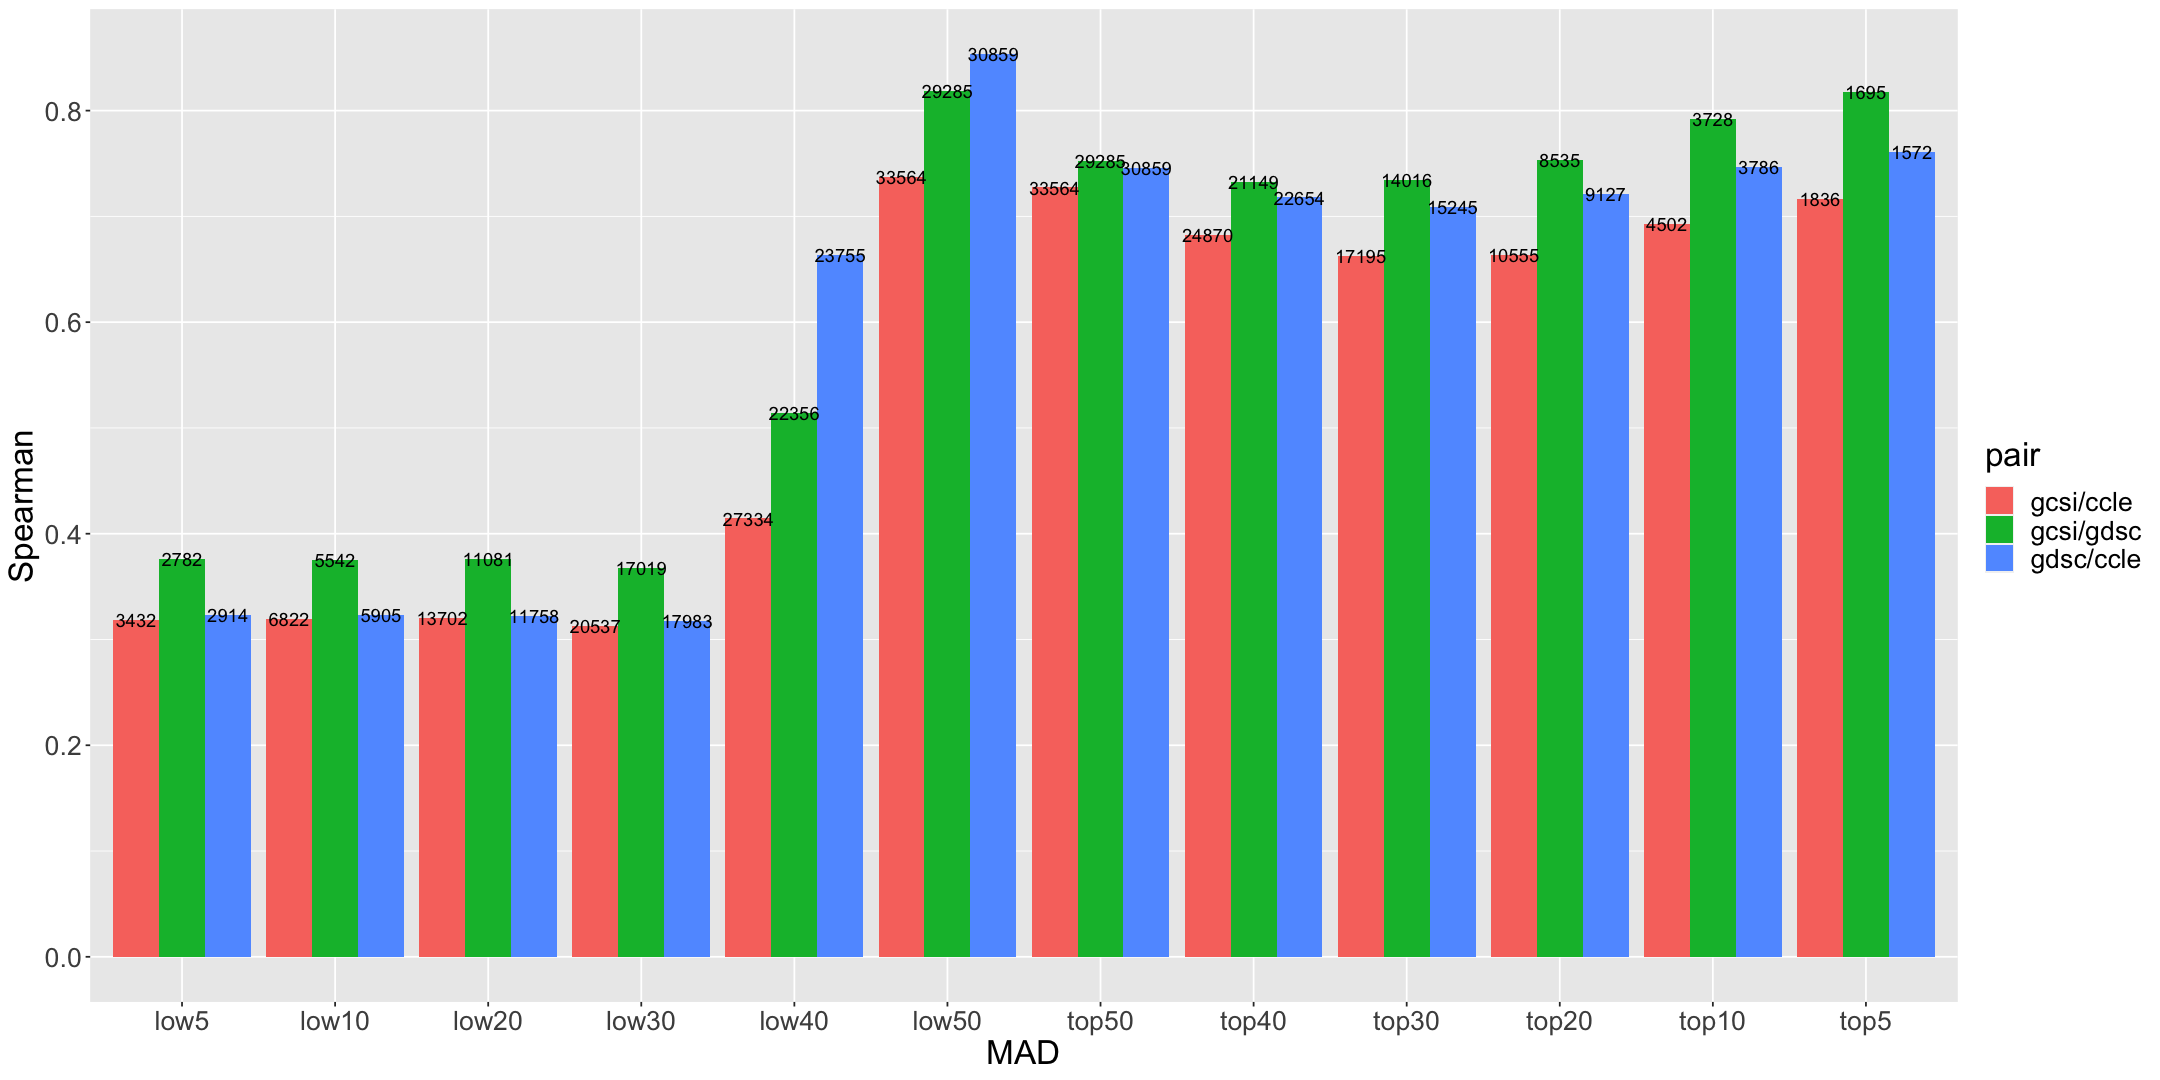

In [308]:
options(repr.plot.width=18, repr.plot.height=9)
level_order <- factor(combined_corr$mad, level = c('low5', 'low10', 'low20', 'low30', 'low40','low50',"top50","top40","top30","top20","top10","top5"))
ggplot(combined_corr, aes(fill=pair, y=cor, x=level_order)) + 
    geom_bar(position="dodge", stat="identity") + theme(plot.title = element_text(hjust = 0.5, size=5), text = element_text(size=20)) +
  xlab("MAD")+ylab("Spearman") + geom_text(aes(label=len, group=pair), position=position_dodge(.9), hjust=.5)

### MAD threshold definition for proten-coding genes (N=25,000)

#### SummarizeMolecularProfiles for gene counts

In [310]:
gCSI_rna <- summarizeMolecularProfiles(pSet = gCSI, mDataType = "Kallisto_0.46.1.rnaseq.counts", cell.lines = intersected_rnacells)
GDSC_rna <- summarizeMolecularProfiles(pSet = GDSC, mDataType = "Kallisto_0.46.1.rnaseq.counts", cell.lines = intersected_rnacells)
CCLE_rna <- summarizeMolecularProfiles(pSet = CCLE, mDataType = "Kallisto_0.46.1.rnaseq.counts", cell.lines = intersected_rnacells)

Summarizing Kallisto_0.46.1.rnaseq.counts molecular data for:	gCSI



  |======================================================================| 100%


Summarizing Kallisto_0.46.1.rnaseq.counts molecular data for:	GDSC_v2



  |======================================================================| 100%


#### compute MAD for each gene across datasets

In [312]:
genes <- gCSI_rna@elementMetadata$gene_id
gene_stability <- data.frame(matrix(nrow=length(genes), ncol=4))
colnames(gene_stability) <- c("gene_id", "gcsi_mad","ccle_mad","gdsc_mad")
gene_stability$gene_id <- genes
rownames(gene_stability) <- gene_stability$gene_id

In [313]:
for (i in 1:length(genes)){

  expr_gcsi <- as.numeric(gCSI_rna@assays@data$exprs[i,])
  expr_gcsi_mad <- mad(expr_gcsi)
  
  expr_ccle <- as.numeric(CCLE_rna@assays@data$exprs[i,])
  expr_ccle_mad <- mad(expr_ccle)

  expr_gdsc <- as.numeric(GDSC_rna@assays@data$exprs[i,])
  expr_gdsc_mad <- mad(expr_gdsc)

  if (is.na(expr_gcsi_mad) | is.na(expr_ccle_mad) | is.na(expr_gdsc_mad)){
    next
    
  } else {
  
  gene_stability[i,"gcsi_mad"] <- expr_gcsi_mad
  gene_stability[i,"ccle_mad"]<- expr_ccle_mad
  gene_stability[i,"gdsc_mad"] <- expr_gdsc_mad
  
  }
}

#### Filter for protein-coding genes only

In [ ]:
protein_genes <- gCSI@molecularProfiles$Kallisto_0.46.1.isoforms@elementMetadata$transcript_id[which(gCSI@molecularProfiles$Kallisto_0.46.1.isoforms@elementMetadata$transcript_type == "protein_coding")]
transcript_stability_p <- transcript_stability[protein_transcripts[which(protein_transcripts %in% rownames(transcript_stability))],]

#### Remove genes with 0 expression & keep resulting genes shared between datasets

In [289]:
expr_gcsi_p <- expr_gcsi_p[apply(expr_gcsi_p[,-1], 1, function(x) !all(x==0)),]
expr_ccle_p <- expr_ccle_p[apply(expr_ccle_p[,-1], 1, function(x) !all(x==0)),]
expr_gdsc_p <- expr_gdsc_p[apply(expr_gdsc_p[,-1], 1, function(x) !all(x==0)),]

In [290]:
intersected_t <- Reduce(intersect, list(rownames(expr_gcsi_p), rownames(expr_ccle_p), rownames(expr_gdsc_p)))
expr_gcsi_p <- expr_gcsi_p[intersected_t,]
expr_ccle_p <- expr_ccle_p[intersected_t,]
expr_gdsc_p <- expr_gdsc_p[intersected_t,]

transcript_stability_p <- transcript_stability_p[intersected_t,]

### Feature vs protein-coding transcript stability correlation

### Heatmap of transcript count across replicates

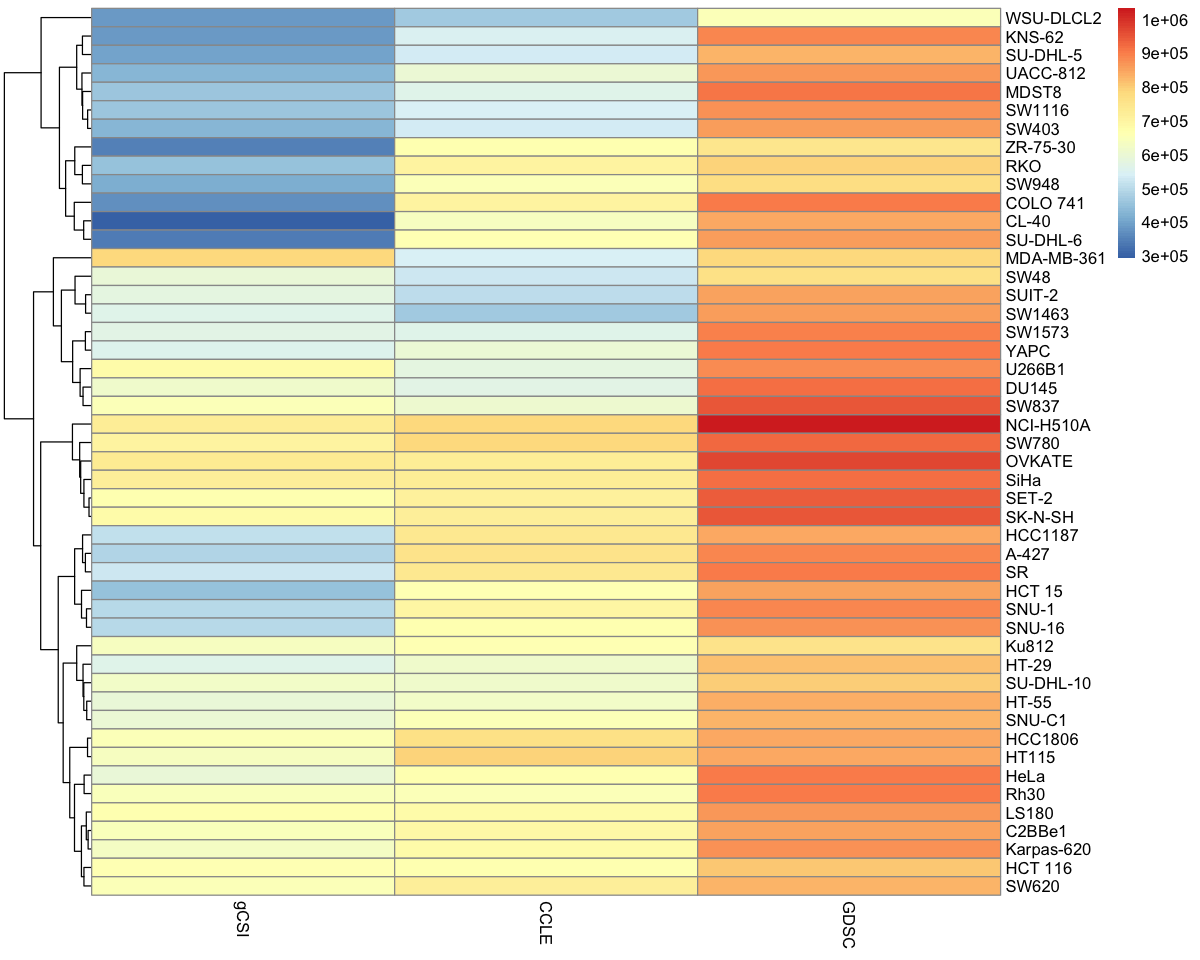

In [16]:
transcript_combined <- data.frame("gcsi"=as.numeric(colSums(gCSI_rna@assays@data$exprs)), 
                            "ccle"=as.numeric(colSums(CCLE_rna@assays@data$exprs)), 
                            "gdsc"=as.numeric(colSums(GDSC_rna@assays@data$exprs))
                            )

rownames(transcript_combined) <- intersected_rnacells
colnames(transcript_combined) <- c("gCSI","CCLE","GDSC")
transcript_combined <- as.matrix(transcript_combined)

options(repr.plot.width=10, repr.plot.height=8)
pheatmap(transcript_combined, cluster_rows=TRUE, show_rownames=TRUE,
         cluster_cols=FALSE)

### Sample-to-sample relationships (PCA)

In [17]:
gcsi_m <- as.data.frame(gCSI_rna@assays@data$exprs)
ccle_m <- as.data.frame(CCLE_rna@assays@data$exprs)
gdsc_m <- as.data.frame(GDSC_rna@assays@data$exprs)

colnames(gcsi_m) <- paste0("gcsi_", colnames(gcsi_m))
colnames(ccle_m) <- paste0("ccle_", colnames(ccle_m))
colnames(gdsc_m) <- paste0("gdsc_", colnames(gdsc_m))

combined_m <- as.data.frame(as.matrix(t(cbind.data.frame(gcsi_m,ccle_m,gdsc_m))))
combined_m <- combined_m
combined_m$dataset <- NA
combined_m$dataset[1:48] <- 'gCSI'
combined_m$dataset[49:96] <- 'CCLE'
combined_m$dataset[97:144] <- 'GDSC'

tt <- PCA(combined_m[,-227913], graph = FALSE)

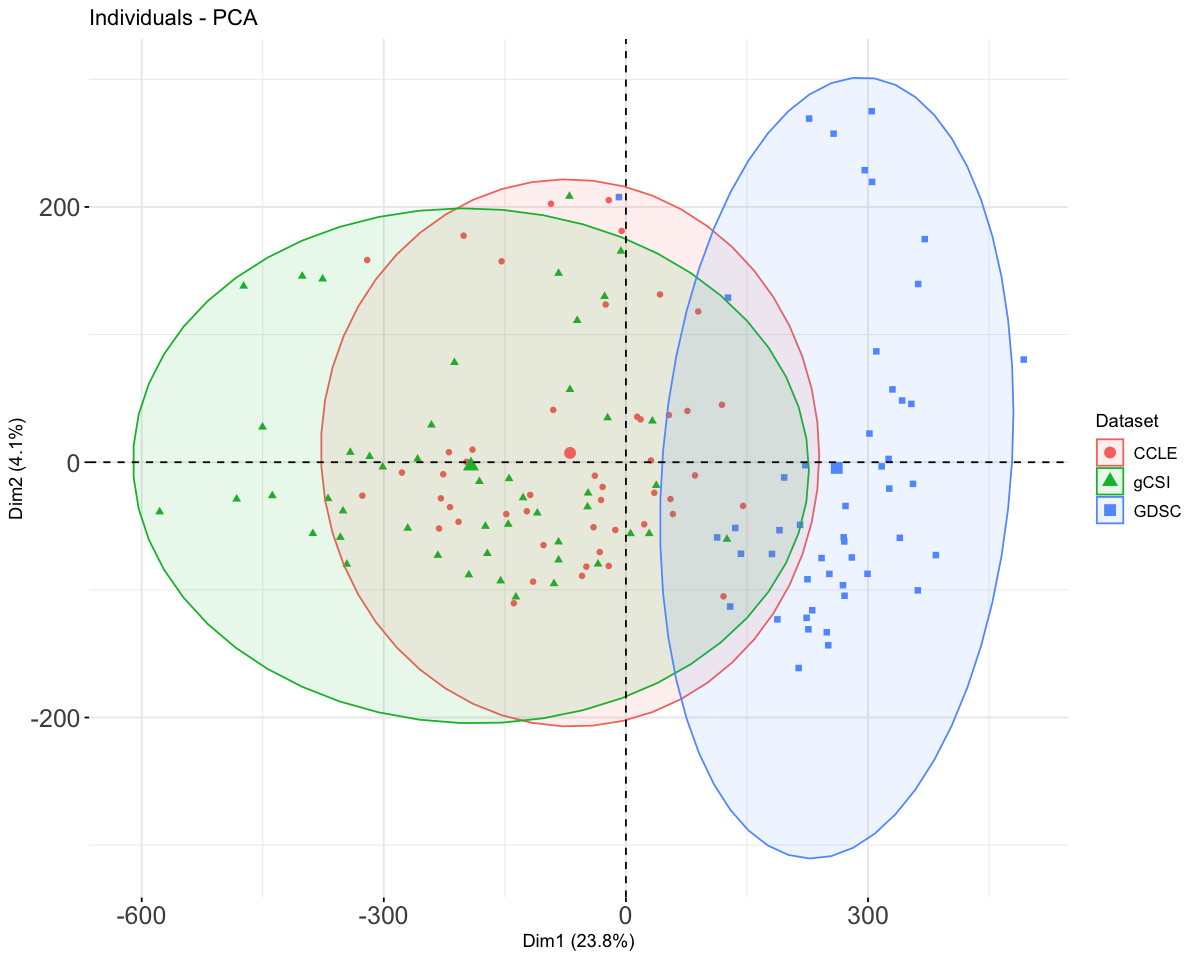

In [20]:
options(repr.plot.width=10, repr.plot.height=8)
fviz_pca_ind(tt,
             geom.ind = "point", # show points only (but not "text")
             col.ind = combined_m$dataset, # color by groups
             addEllipses = TRUE, # Concentration ellipses
             legend.title = "Dataset",
             labelsize = 15
) + theme(
    legend.text = element_text(size = 10),
    axis.text = element_text(size = 15)
  )

# (2) <u> Use clustering to interpret transcript stability</u>

## Hierarchical clustering

In [19]:
#remove rows with all 0's from exp matrix
expr_gcsi_p_fil <- expr_gcsi_p[apply(expr_gcsi_p[,-1], 1, function(x) !all(x==0)),]
expr_ccle_p_fil <- expr_ccle_p[apply(expr_ccle_p[,-1], 1, function(x) !all(x==0)),]
expr_gdsc_p_fil <- expr_gdsc_p[apply(expr_gdsc_p[,-1], 1, function(x) !all(x==0)),] 

#### Create clustering matrix for each dataset

In [20]:
#gCSI
hclust_matrix <- expr_gcsi_p_fil
hclust_matrix <- hclust_matrix %>% 
  # transpose the matrix so transcripts are as columns
  t() %>% 
  # apply scalling to each column of the matrix (transcripts). Before clustering we need to scale the data. This is so that we can identify clusters of transcripts that share similar count profiles rather than similar count levels.
  scale() %>% 
  # transpose back so transcripts are as rows again
  t()

#### Compute distance between transcripts

In [22]:
transcript_dist <- dist(hclust_matrix[1:20000,])
transcript_hclust <- hclust(transcript_dist, method = "complete")

#### Plot hierarchical cluster

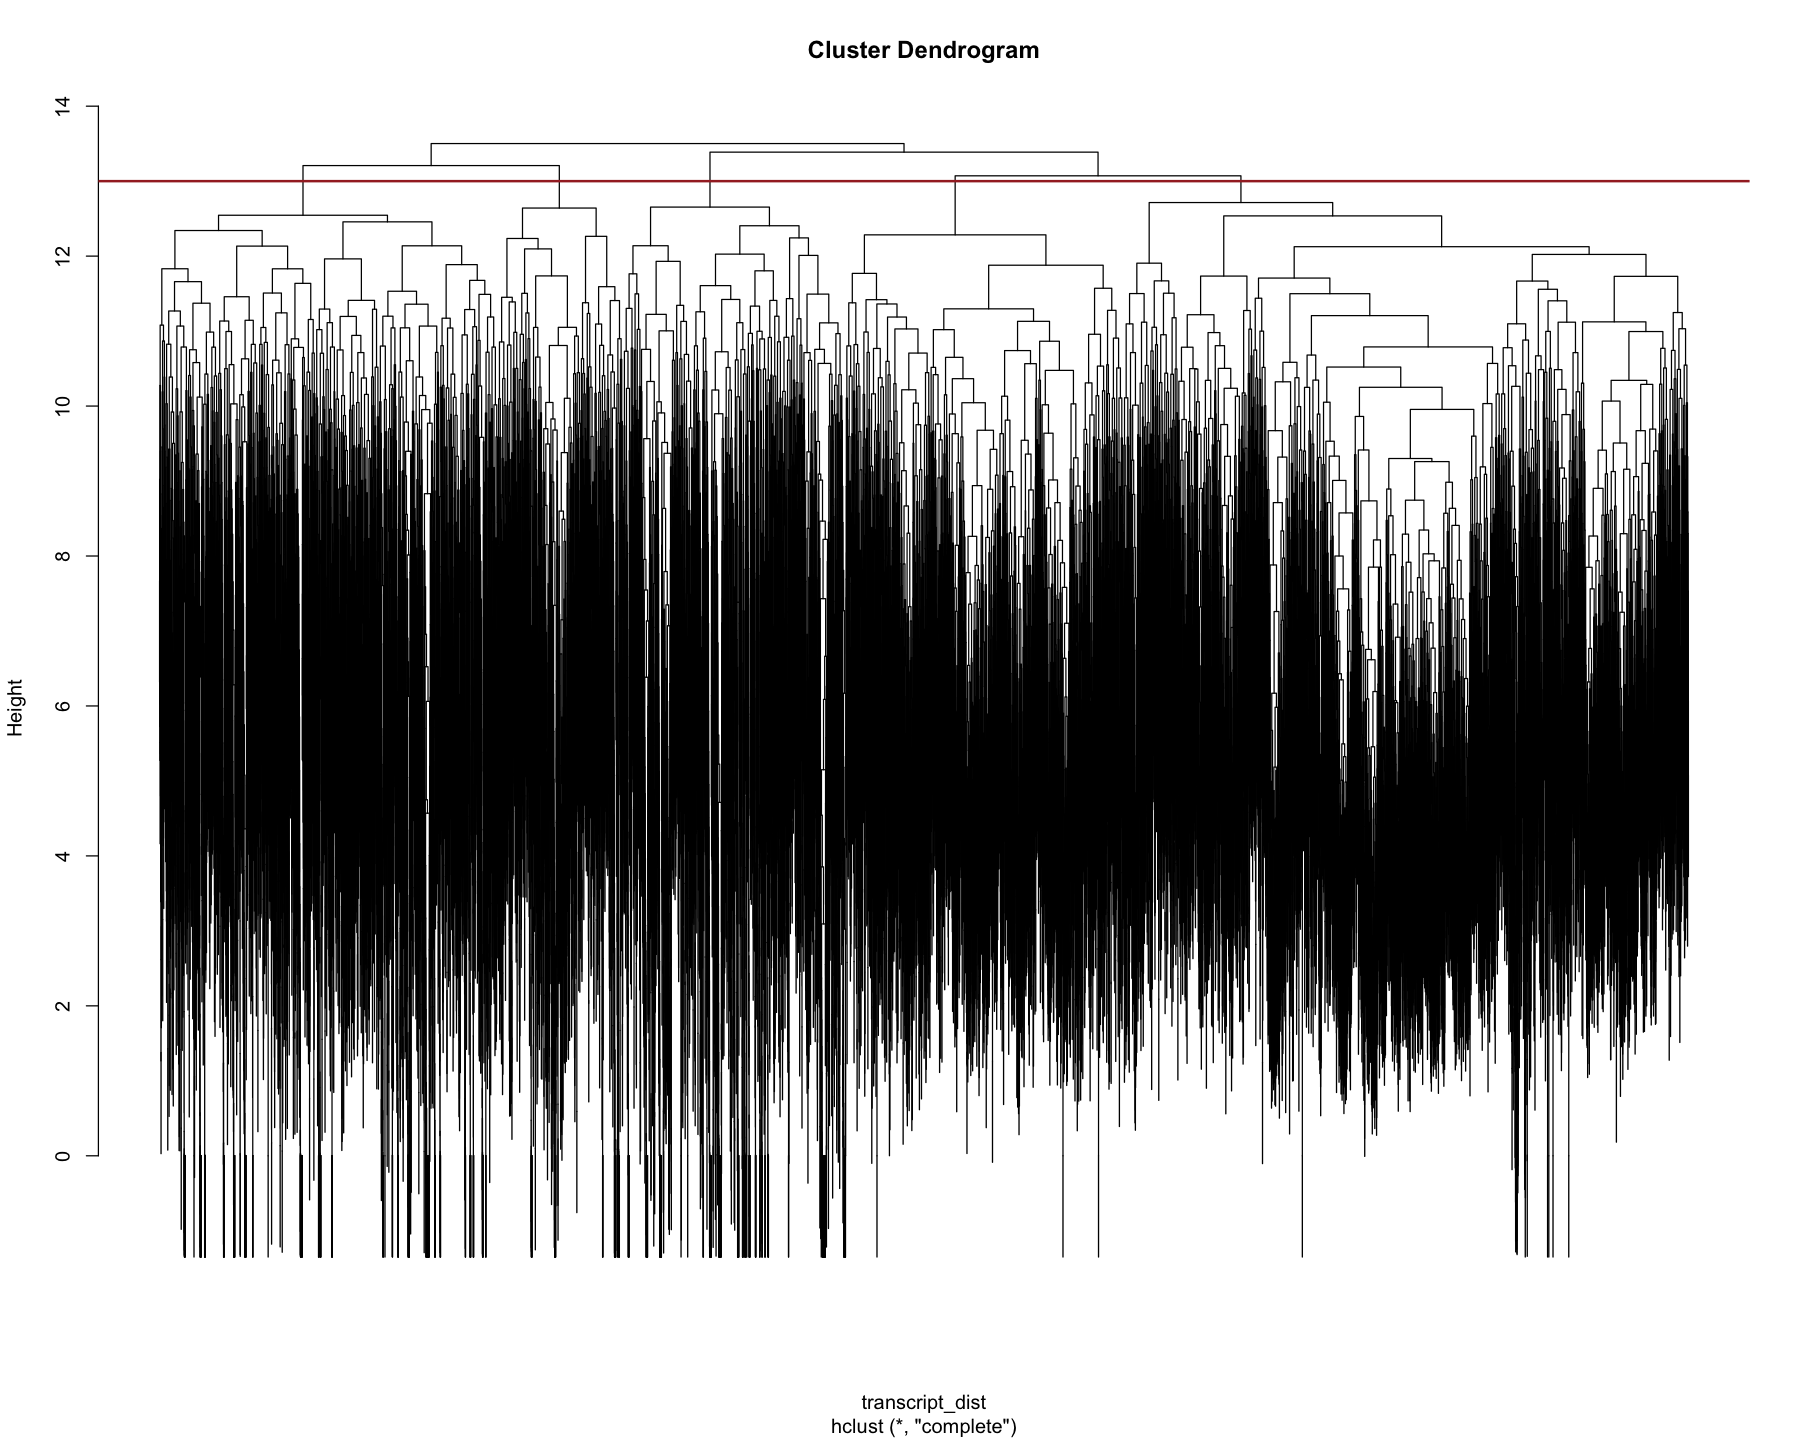

In [36]:
options(repr.plot.width=15, repr.plot.height=12)
plot(transcript_hclust, labels = FALSE)
abline(h = 13, col = "brown", lwd = 2)

#### Cut dendrogram

In [39]:
transcript_cluster <- cutree(transcript_hclust, k = 5) %>% 
  # turn the named vector into a tibble
  enframe()

In [40]:
nrow(transcript_cluster)

[1] 20000

# (3) <u> Create regression model to predict transcript stability</u>

### Extract feature data from Ensembl

#### transcript %GC content + transcript length

In [23]:
expr_features <- gCSI@molecularProfiles$Kallisto_0.46.1.isoforms@elementMetadata
expr_features$gene_id_stable <- gsub("\\..*","",expr_features$gene_id)

#use EDAseq package for retrieving gene %GC content & gene length from Ensembl GeneID
#length_gc <- getGeneLengthAndGCContent(expr_features$gene_id_stable, "hsa") #this takes about 30-40 min
#load("ensembl_length_gc.RData") #loads in gene length_gc

#transcript length from biomart ensembl
ensembl_features <- read.csv("ensembl_hg38_features.txt")
ensembl_features$transcript_length <- ensembl_features$Transcript.length..including.UTRs.and.CDS.

#transcript gc content(%) from AnnotationHub
require("ensembldb")
tt <- query(AnnotationHub(),"EnsDb", "v98")
tt <- subset(tt, species == "Homo sapiens") #identifies AH78783 as human ensembl v98
edb <- AnnotationHub()[["AH78783"]]
transcripts <- transcripts(edb)

snapshotDate(): 2020-04-27

snapshotDate(): 2020-04-27

loading from cache



#### miRNA binding sites

In [15]:
#miRNA binding sites
ensembl_features_miRNA <- read.csv("ensembl_hg38_features_miRNA.txt", sep = "\t") #miRNA bindings to gene

#get total # of miRNA binding sites per gene
mirna_total <- ensembl_features_miRNA %>% 
  group_by(Ensembl.gene.ID) %>% 
  summarise(miRNA.identifier = n_distinct(miRNA.identifier))

`summarise()` ungrouping output (override with `.groups` argument)



#### Exon rank in transcript

In [24]:
ensembl_features_rank <- read.csv("ensembl_hg38_features_exon_rank.txt", sep = "\t")

#### Number of exons in transcript

In [25]:
#exon number
ensembl_features_exon <- read.csv("ensembl_hg38_features_exon.txt")

#get total # of exons per transcript
exon_total <- ensembl_features_exon %>% 
  group_by(ensembl_features_exon$Transcript.stable.ID.version) %>% 
  summarise(Exon.stable.ID = n_distinct(Exon.stable.ID))

`summarise()` ungrouping output (override with `.groups` argument)



#### Codon frequency per transcript

In [117]:
mrna = readDNAStringSet("gencode.v33.transcripts.fa")
freq <- oligonucleotideFrequency(mrna, width = 3, step = 3, as.prob = TRUE)
rownames(freq) <- gsub("\\|.*", "", names(mrna))

### Assemble feature data into dataframe

In [162]:
feature_df <- as.data.frame(matrix(NA, nrow = 227912))
feature_df$transcript_id <- as.character(gCSI@molecularProfiles$Kallisto_0.46.1.isoforms@elementMetadata$transcript_id)
#feature_df$rank <- ensembl_features_rank$Exon.rank.in.transcript[match(feature_df$transcript_id, ensembl_features_rank$Transcript.stable.ID.version)]
feature_df$t_length <- ensembl_features$transcript_length[match(feature_df$transcript_id, ensembl_features$Transcript.stable.ID.version)]
feature_df$t_gc <- transcripts$gc_content[match(feature_df$transcript_id, transcripts$tx_id_version)]
feature_df$exon_num <- exon_total$Exon.stable.ID[match(feature_df$transcript_id, exon_total$`ensembl_features_exon$Transcript.stable.ID.version`)]
feature_df$type <- gCSI@molecularProfiles$Kallisto_0.46.1.isoforms@elementMetadata$transcript_type[match(feature_df$transcript_id, gCSI@molecularProfiles$Kallisto_0.46.1.isoforms@elementMetadata$transcript_id)]
feature_df$V1 <- NULL
rownames(feature_df) <- feature_df$transcript_id 
feature_df$transcript_id <- NULL

In [163]:
feature_df <- cbind(feature_df, freq)

### Assign MEAN of feature for any NAs

In [164]:
#miRNA binding site count
#expr_features <- expr_features[match(mirna_total$Ensembl.gene.ID,expr_features$gene_id_stable),]
#expr <- expr[match(mirna_total$Ensembl.gene.ID,expr_features$gene_id_stable),] #only 14,000/60,000 kept
#expr$mirna <- mirna_total$miRNA.identifier[match(expr_features$gene_id_stable,mirna_total$Ensembl.gene.ID)]
#mean_mirna <- mean(expr$mirna[which(!is.na(expr$mirna))])
#expr$mirna[which(is.na(expr$mirna))] <- mean_mirna

#Exon rank in transcript
#mean_rank <- mean(feature_df$rank[which(!is.na(feature_df$rank))])
#feature_df$rank[which(is.na(feature_df$rank))] <- mean_rank

#Transcript length
mean_transcript_length <- mean(feature_df$t_length[which(!is.na(feature_df$t_length))])
feature_df$t_length[which(is.na(feature_df$t_length))] <- mean_transcript_length

#Transcript GC %
mean_gc <- mean(feature_df$t_gc[which(!is.na(feature_df$t_gc))])
feature_df$t_gc[which(is.na(feature_df$t_gc))] <- mean_gc

#Exon number in transcript
mean_exon_num <- mean(feature_df$exon_num[which(!is.na(feature_df$exon_num))])
feature_df$exon_num[which(is.na(feature_df$exon_num))] <- mean_exon_num

### Keep transcripts that have high MAD for training (unstable across datasets) N=159316

In [165]:
transcript_stability <- transcript_stability[which(transcript_stability$combined_mad >= 2),]

In [166]:
feature_df_x <- feature_df[which(rownames(feature_df) %in% rownames(transcript_stability)),]

In [167]:
nrow(feature_df_x)

[1] 28051

### Add transcript stability correlation to feature dataframe

In [168]:
feature_df_x$pearson <- transcript_stability$pearson[match(rownames(feature_df_x), transcript_stability$transcript_id)]
#feature_df_x <- feature_df_x[-which(is.na(feature_df_x$pearson)),] #remove transcripts with NA (~8% removed)

### Use model.matrix to convert categorical variables in feature df to numerical (e.g. transcript_type)

In [169]:
feature_df_x <- model.matrix( ~ .-1, feature_df_x)

In [170]:
head(feature_df_x)

,t_length,t_gc,exon_num,typeIG_C_gene,typeIG_V_gene,typeIG_V_pseudogene,typelncRNA,typemiRNA,typemisc_RNA,typenon_stop_decay,⋯,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT,pearson
ENST00000494149.2,755,67.68212,1,0,0,0,0,0,0,0,⋯,0.03187251,0.003984064,0.01195219,0.007968127,0.000000000,0.00000000,0.007968127,0.007968127,0.007968127,0.67233187
ENST00000595919.1,284,64.43662,1,0,0,0,0,0,0,0,⋯,0.05319149,0.000000000,0.01063830,0.021276596,0.000000000,0.00000000,0.010638298,0.021276596,0.010638298,0.78138058
ENST00000490997.5,518,48.64865,3,0,0,0,1,0,0,0,⋯,0.00000000,0.023255814,0.01162791,0.040697674,0.005813953,0.01162791,0.005813953,0.011627907,0.011627907,0.08735576
ENST00000491962.1,278,45.68345,3,0,0,0,1,0,0,0,⋯,0.01086957,0.076086957,0.02173913,0.032608696,0.021739130,0.01086957,0.021739130,0.021739130,0.010869565,0.44735759
ENST00000410691.1,104,39.42308,1,0,0,0,0,0,0,0,⋯,0.00000000,0.000000000,0.02941176,0.029411765,0.029411765,0.00000000,0.000000000,0.029411765,0.058823529,0.26391024
ENST00000496488.1,457,40.04376,2,0,0,0,1,0,0,0,⋯,0.01973684,0.019736842,0.02631579,0.013157895,0.013157895,0.00000000,0.006578947,0.006578947,0.032894737,0.33184414


### Plot feature distribution (feature vs transcript stability)

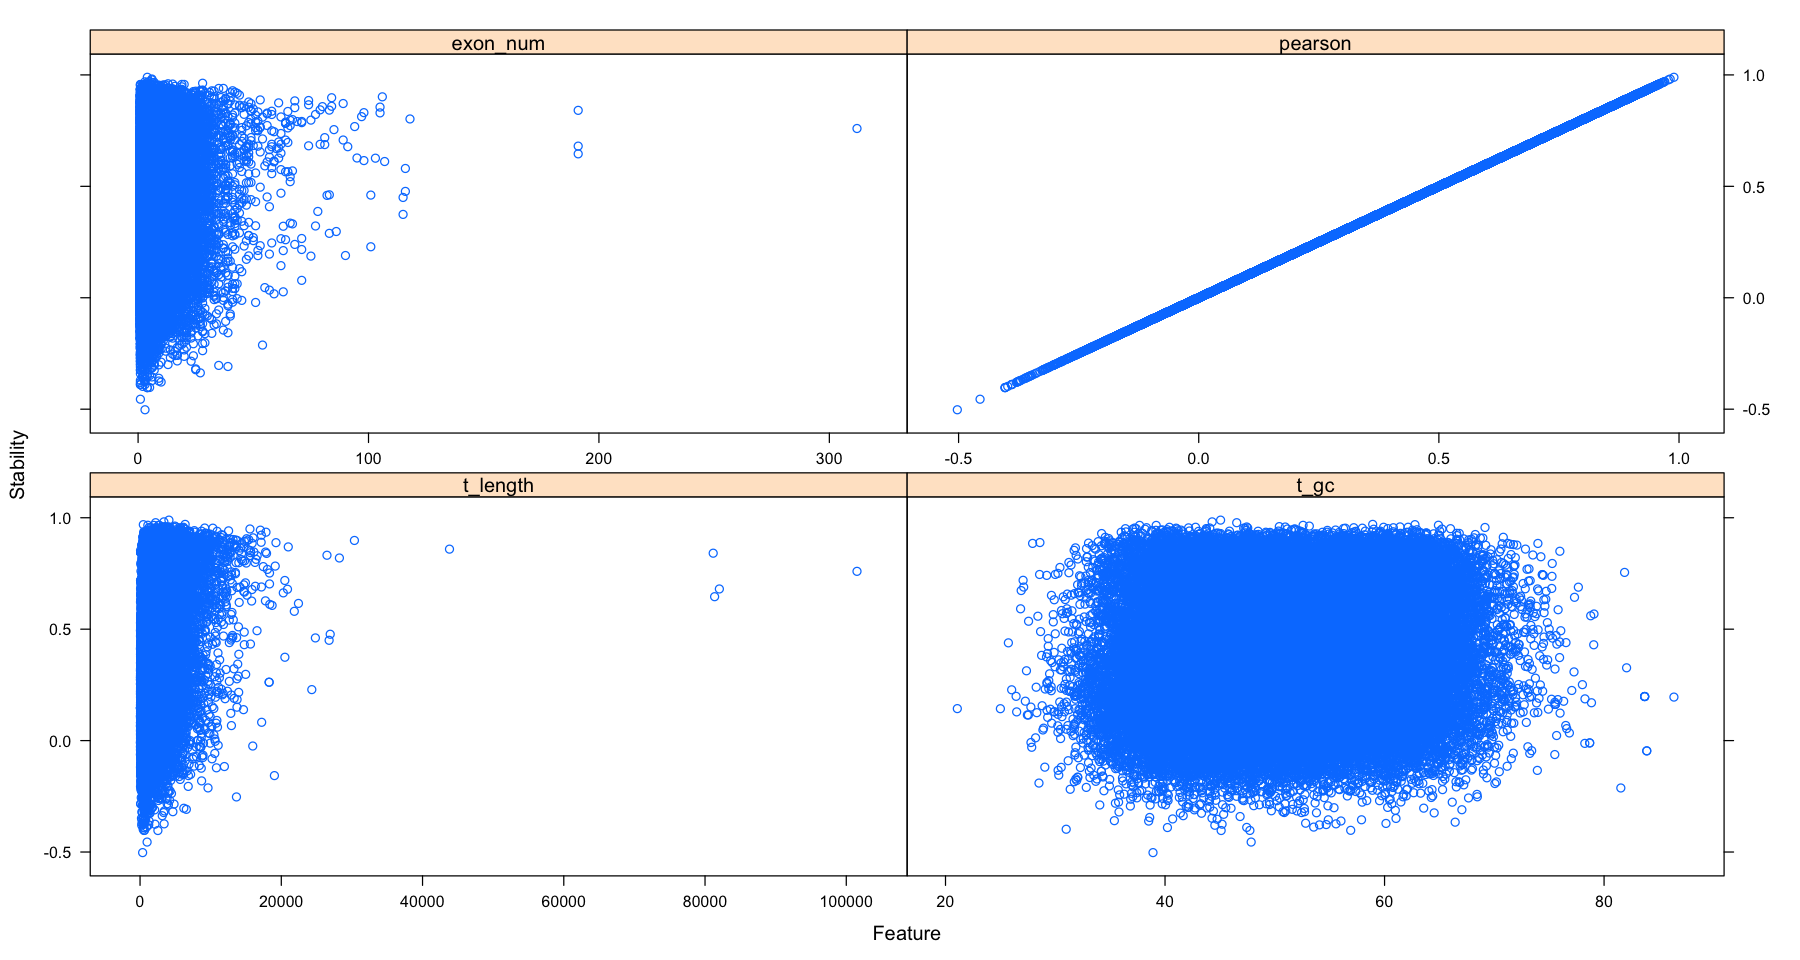

In [111]:
#use one cell line as example
expr_sub <- feature_df_x[1:50000, ]
options(repr.plot.width=15, repr.plot.height=8)
featurePlot(x = expr_sub, y = expr_sub[,"pearson"], labels = c("Feature", "Stability"))

# 1. <u>Elastic Net with K-fold cross validation</u>

In [159]:
set.seed(123)

### Train model

In [171]:
transcript_model <- train(
  pearson ~., #y-values (trying one sample)
  data=feature_df_x, #df with rows as samples and columns as features
  method = "glmnet",
  trControl = trainControl(
    method = "cv", 
    number = 10,
    verboseIter = TRUE
  )
)

+ Fold01: alpha=0.10, lambda=0.014 
- Fold01: alpha=0.10, lambda=0.014 
+ Fold01: alpha=0.55, lambda=0.014 
- Fold01: alpha=0.55, lambda=0.014 
+ Fold01: alpha=1.00, lambda=0.014 
- Fold01: alpha=1.00, lambda=0.014 
+ Fold02: alpha=0.10, lambda=0.014 
- Fold02: alpha=0.10, lambda=0.014 
+ Fold02: alpha=0.55, lambda=0.014 
- Fold02: alpha=0.55, lambda=0.014 
+ Fold02: alpha=1.00, lambda=0.014 
- Fold02: alpha=1.00, lambda=0.014 
+ Fold03: alpha=0.10, lambda=0.014 
- Fold03: alpha=0.10, lambda=0.014 
+ Fold03: alpha=0.55, lambda=0.014 
- Fold03: alpha=0.55, lambda=0.014 
+ Fold03: alpha=1.00, lambda=0.014 
- Fold03: alpha=1.00, lambda=0.014 
+ Fold04: alpha=0.10, lambda=0.014 
- Fold04: alpha=0.10, lambda=0.014 
+ Fold04: alpha=0.55, lambda=0.014 
- Fold04: alpha=0.55, lambda=0.014 
+ Fold04: alpha=1.00, lambda=0.014 
- Fold04: alpha=1.00, lambda=0.014 
+ Fold05: alpha=0.10, lambda=0.014 
- Fold05: alpha=0.10, lambda=0.014 
+ Fold05: alpha=0.55, lambda=0.014 
- Fold05: alpha=0.55, lambda

In [172]:
transcript_model

glmnet 

28051 samples
   94 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 25247, 25246, 25246, 25245, 25246, 25247, ... 
Resampling results across tuning parameters:

  alpha  lambda        RMSE       Rsquared   MAE      
  0.10   0.0001399583  0.2564038  0.1386090  0.2131921
  0.10   0.0013995831  0.2563877  0.1387059  0.2132356
  0.10   0.0139958306  0.2566188  0.1381969  0.2140766
  0.55   0.0001399583  0.2564023  0.1386475  0.2131839
  0.55   0.0013995831  0.2563911  0.1390025  0.2133924
  0.55   0.0139958306  0.2593542  0.1249851  0.2174581
  1.00   0.0001399583  0.2563939  0.1387196  0.2131931
  1.00   0.0013995831  0.2565005  0.1387294  0.2136175
  1.00   0.0139958306  0.2617107  0.1132305  0.2202841

RMSE was used to select the optimal model using the smallest value.
The final values used for the model were alpha = 0.1 and lambda = 0.001399583.